### 01. Import Dependecies

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from category_encoders.target_encoder import TargetEncoder
# Note: SMOTE will be applied during model training in the pipeline (notebook 06)

### 02. Import data

In [2]:
df = pd.read_csv("data/processed/feature_binning.csv")
df.head()

,purchase_value,source,browser,sex,age,class,account_age_minutes,device_count,user_count_per_device,country
0,34,SEO,Chrome,M,Middle-aged,0,75111.37,1,1,Japan
1,16,Ads,Chrome,F,Middle-aged,0,299.07,1,1,United States
2,15,SEO,Opera,M,Middle-aged,1,0.02,12,12,United States
3,44,SEO,Safari,M,Middle-aged,0,8201.42,1,1,Unknown
4,39,Ads,Safari,M,Middle-aged,0,72691.02,1,1,United States


In [3]:
df.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'class',
       'account_age_minutes', 'device_count', 'user_count_per_device',
       'country'],
      dtype='object')

### 03. Data Preprocessing

In [4]:
ordinal_features = ["age"]

nominal_features = [
    "source",
    "browser",
    "sex"
]

target_encode_features = ["country"]

numerical_features = [
    "purchase_value",
    "account_age_minutes",
    "device_count",
    "user_count_per_device"
]

target = "class"


### 04. Data splting

In [5]:
X = df.drop(columns=[target])
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 05 Preprocessing: encoding + scaling

In [7]:
target_encoder = TargetEncoder(
    smoothing=10,        # higher = more smoothing
    min_samples_leaf=20  # categories with <20 samples heavily smoothed
)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numerical_features),
        ("ord", OrdinalEncoder(), ordinal_features),
        ("nom", OneHotEncoder(handle_unknown="ignore", sparse_output=False), nominal_features),
        ("target", target_encoder, target_encode_features)
    ],
    remainder="drop"
)


#### 5.1 FIT on TRAIN only

In [9]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)

#### 5.2 TRANSFORM test (no fit)

In [10]:
X_test_processed = preprocessor.transform(X_test)

In [11]:
joblib.dump(preprocessor, "artifacts/preprocessor.joblib")

['artifacts/preprocessor.joblib']

#### 5.3 Recover feature names

In [12]:
onehot_feature_names = preprocessor.named_transformers_[
    "nom"
].get_feature_names_out(nominal_features)

feature_names = (
    numerical_features +
    ordinal_features +
    list(onehot_feature_names) +
    target_encode_features
)


In [13]:
X_train_processed = pd.DataFrame(
    X_train_processed,
    columns=feature_names
)

X_test_processed = pd.DataFrame(
    X_test_processed,
    columns=feature_names
)

### 6. Class Distribution Visualization

**Note:** SMOTE will be applied during model training (in the pipeline) to ensure proper cross-validation. 
We save the original (unbalanced) training data here.

In [14]:
# SMOTE will be applied during model training in the pipeline (notebook 06)
# This ensures SMOTE is applied correctly within each CV fold
# We keep the original (unbalanced) training data here

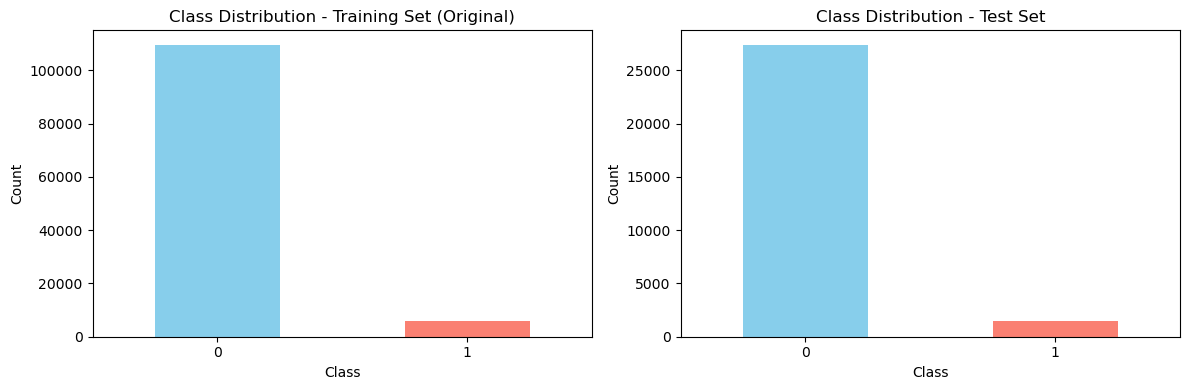


Training set class distribution:
class
0    109568
1      5849
Name: count, dtype: int64

Test set class distribution:
class
0    27393
1     1462
Name: count, dtype: int64


In [15]:
plt.figure(figsize=(12, 4))

# Training Set (original, unbalanced)
plt.subplot(121)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution - Training Set (Original)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Test Set
plt.subplot(122)
y_test.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

### Saving Dataset

In [16]:
# Save original (unbalanced) training data
# SMOTE will be applied during model training in the pipeline (notebook 06)
# This ensures proper cross-validation without data leakage
np.savez('artifacts/X_train.npz', X_train_processed.values)
np.savez('artifacts/Y_train.npz', y_train.values)

# Save test data (original, not resampled)
np.savez('artifacts/X_test.npz', X_test_processed.values)
np.savez('artifacts/Y_test.npz', y_test.values)

print("✓ Training data saved (original - unbalanced)")
print("✓ Test data saved (original - not resampled)")
print(f"\nTraining set shape: {X_train_processed.shape}")
print(f"Test set shape: {X_test_processed.shape}")
print(f"\nNote: SMOTE will be applied during model training in the pipeline")

✓ Training data saved (original - unbalanced)
✓ Test data saved (original - not resampled)

Training set shape: (115417, 16)
Test set shape: (28855, 16)

Note: SMOTE will be applied during model training in the pipeline
